# SparkDev AI Hurricane Trajectory Prediction

In this project, we'll be using neural networks to predict the trajectory paths of hurricanes in South Florida. We will be using the Hurricane Database dataset from Unisys Weather. Here we will preprocess the data, then train a recurrent neural network on some of the samples. At the end, we'll get to see our neural network's hurricane trajectory path predictions.

### Get and Analyze the Data

[Here's the link containing the entire dataset.](http://weather.unisys.com/hurricane/atlantic/) So far, we're using only the years 2000 to 2009 and is saved on our repo as '2000-2009-data.csv'. We have to get an idea of the hurricanes' behavior to properly create a model for our neural network. 

In [74]:
import pandas as pd
import numpy as np

data = pd.read_csv('2000-2009-data.csv', names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure'])

# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)

# Delete the columns of information that we are not using so far
data.drop(['WindSpeed', 'Pressure', 'Name', 'HurricaneNum', 'Year'], axis = 1, inplace = True)

# Preview the first 5 rows of data
data.head()

,Month,Day,Hour,Lat,Long,unique-key
0,6,7,18,21.0,-93.0,NOTNAMED-2000-1
1,6,8,0,20.9,-92.8,NOTNAMED-2000-1
2,6,8,6,20.7,-93.1,NOTNAMED-2000-1
3,6,8,12,20.8,-93.5,NOTNAMED-2000-1
4,6,23,0,9.5,-19.8,NOTNAMED-2000-2


In [75]:
# Total amount of hurricanes we have in our dataset 
print(len(pd.unique(data['unique-key'])))

174


In [76]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

y = np.zeros((174))
for x in range(0,174):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))

# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

In [77]:
# Provides statistical information about the DataFrame 
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

,0
count,174.000000
mean,29.114943
std,19.370692
min,4.000000
25%,13.000000
50%,26.000000
75%,42.000000
max,94.000000


Top 6 Hurricanes (in terms of data quantity)
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
ALBERTO-2000-3 - 87.0
NICHOLAS-2003-19 - 80.0
FRANCES-2004-6 - 74.0
BERTHA-2008-2 - 74.0


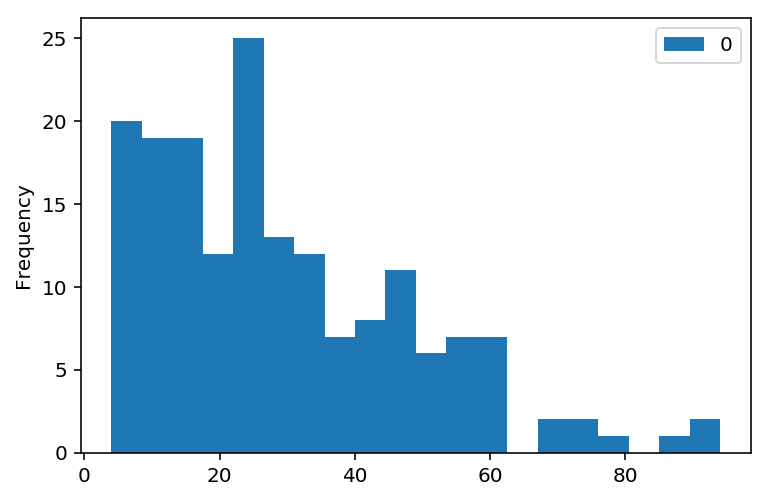

In [78]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

# Print the distribution of data quantity for all 174 hurricanes
hurricane_amount.plot.hist(bins=20)
plt.show()

### Data Preprocessing

From the dataset, we have latitude and longitude. It is easier for the neural network to learn from distance vectors since these values do not contain negative values (like latitude and longitude). To preprocess our data, we will calculate the angle of travel and distance between each given point and add that as new columns to our DataFrame. In addition, we will remove the outlier hurricanes, to get a more normal distribution to insert into the neural network.

In [79]:
from geopy.distance import great_circle as vc
import math as Math

y = np.zeros((174))
data['distance'] = np.zeros((5066))
data['direction'] = np.zeros((5066))

# For all hurricanes
for x in range(0,174):
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['Lat'], t['Long']):
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'distance', vc(prev,p).miles)
        
        dLon = p[1] - prev[1];
        y_x = Math.sin(dLon) * Math.cos(p[0]);
        x_x = Math.cos(p[1]) * Math.sin(p[0]) - Math.sin(p[1]) * Math.cos(p[0]) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction', brng)
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

In [80]:
# Columns have been added
data.head()

,Month,Day,Hour,Lat,Long,unique-key,distance,direction
0,6,7,18,21.0,-93.0,NOTNAMED-2000-1,0.000000,0.000000
1,6,8,0,20.9,-92.8,NOTNAMED-2000-1,14.642489,350.664916
2,6,8,6,20.7,-93.1,NOTNAMED-2000-1,23.806400,7.319681
3,6,8,12,20.8,-93.5,NOTNAMED-2000-1,26.759803,8.981252
4,6,23,0,9.5,-19.8,NOTNAMED-2000-2,0.000000,0.000000


In [81]:
# Here we can see that the hurricane that traveled the least only traveled 65 miles, while the one that traveled the most traveled 8402 miles
hurricane_distance.describe()

,0
count,174.000000
mean,2282.086542
std,1755.959116
min,65.208692
25%,846.958809
50%,1966.235839
75%,3301.331522
max,8402.883735


Top 6 Hurricanes (in terms of distance traveled)
ALBERTO-2000-3 - 8402.88373484 miles - 87.0
IVAN-2004-9 - 7759.7484688 miles - 94.0
KATE-2003-16 - 6394.65717702 miles - 58.0
BILL-2009-3 - 6238.1751903 miles - 46.0
FLORENCE-2006-7 - 6217.95160952 miles - 62.0
BERTHA-2008-2 - 6186.43908039 miles - 74.0


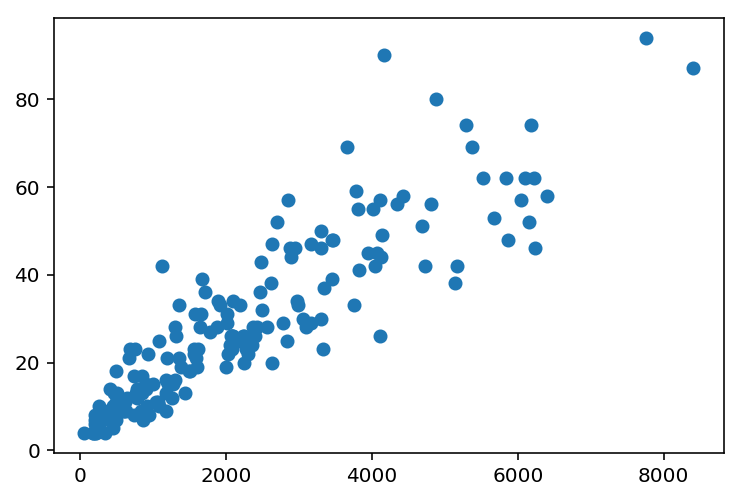

In [82]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])

# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
corr = plt.scatter(hurricane_distance[0], hurricane_amount[0])
plt.show()

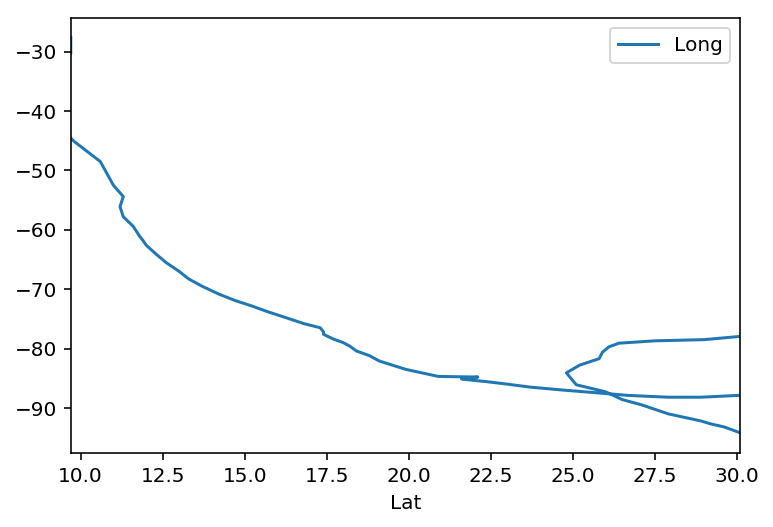

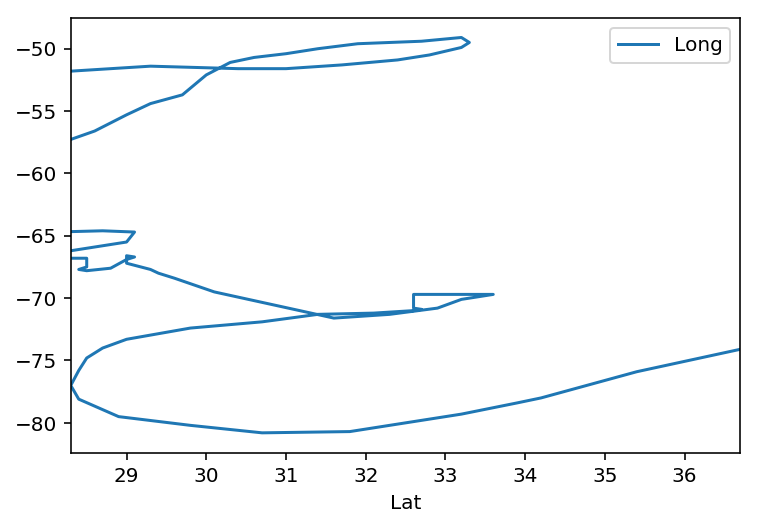

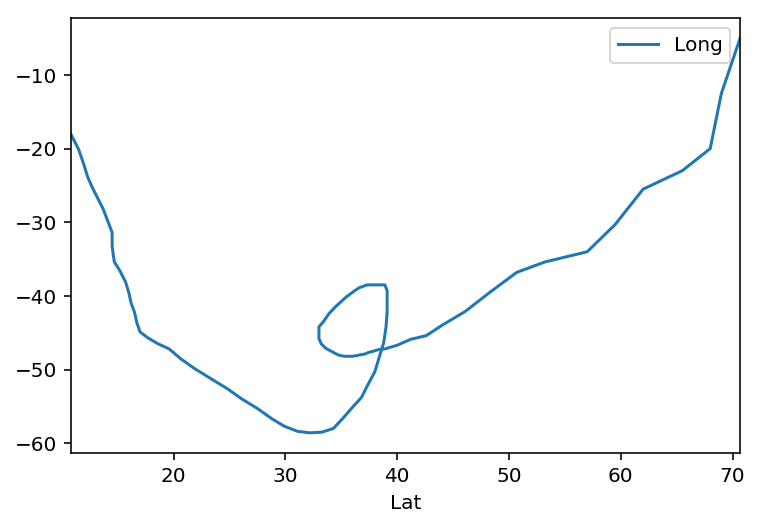

In [83]:
# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
for x in hurricane_amount.nlargest(3, 0).index:
    data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long') 

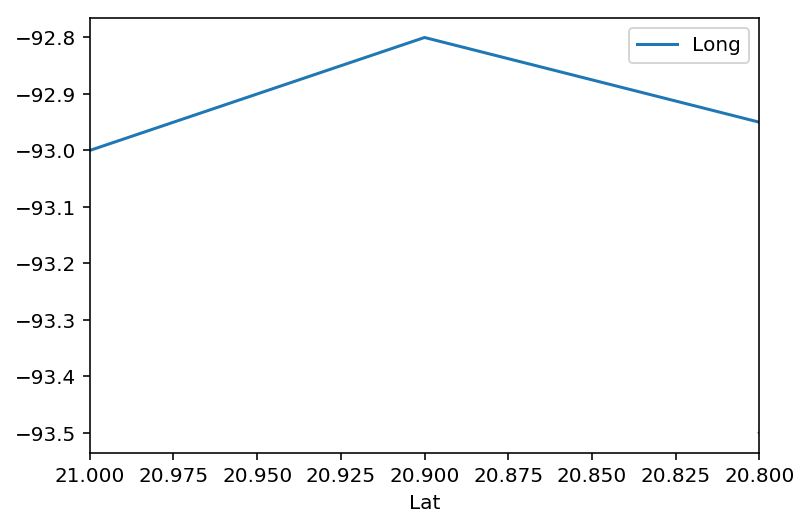

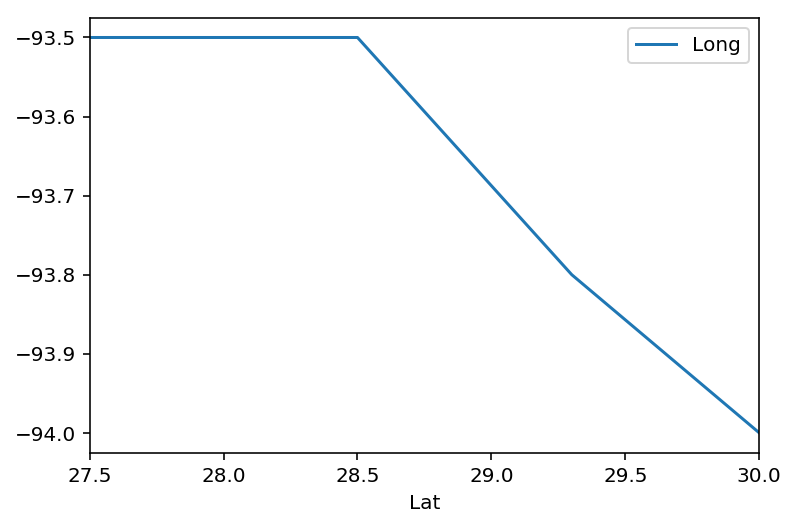

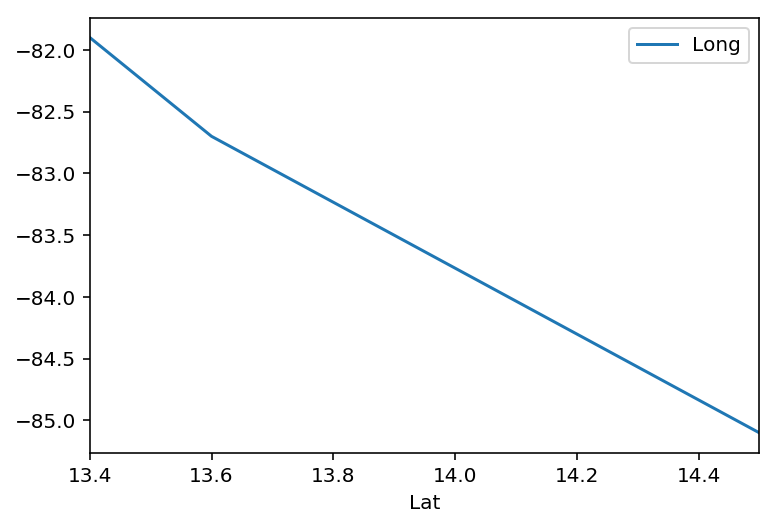

In [84]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
for x in hurricane_amount.nsmallest(3, 0).index:
    data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long')

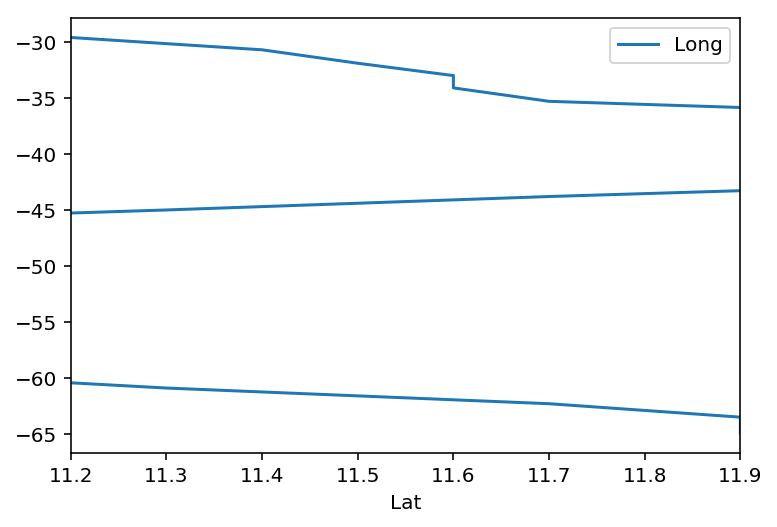

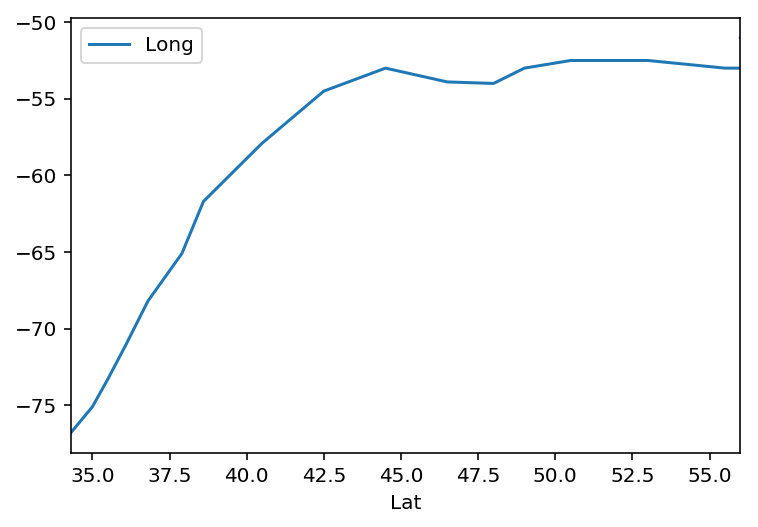

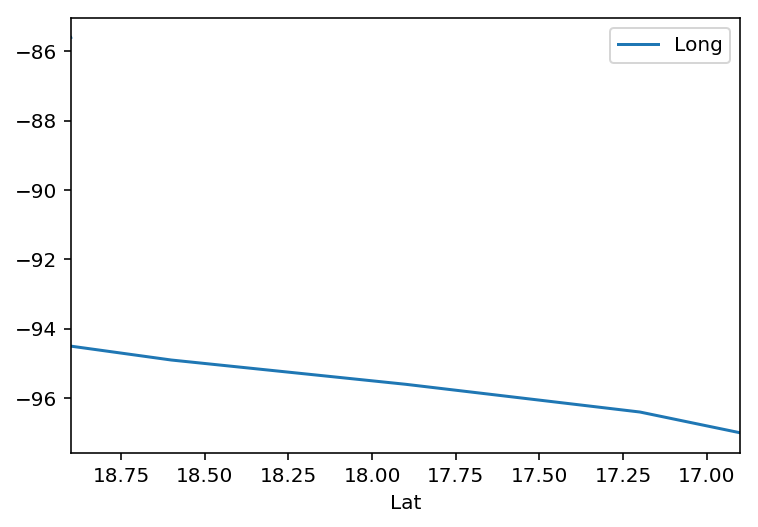

In [85]:
# Graph the trajectories of 3 random hurricanes 
for x in np.random.choice(174, 3):
     data[data['unique-key'] == keys[x][1]].plot(x='Lat', y='Long') 

In [86]:
# We are removing some outliers that contain too little or too much information to keep a more normal distribution.
cond = (hurricane_amount > 13) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]
    
df = data[data['unique-key'].isin(keys25)]
df.head()

,Month,Day,Hour,Lat,Long,unique-key,distance,direction
134,8,19,18,12.0,-44.5,DEBBY-2000-7,0.000000,0.000000
135,8,20,0,12.6,-45.3,DEBBY-2000-7,68.101484,313.591887
136,8,20,6,13.3,-46.8,DEBBY-2000-7,112.017434,230.165829
137,8,20,12,14.0,-48.8,DEBBY-2000-7,142.766983,322.273966
138,8,20,18,14.7,-50.6,DEBBY-2000-7,129.867994,31.781920


In [87]:
# Total amount of hurricanes we have now 
print(len(pd.unique(df['unique-key'])))

116


In [108]:
# Description of our new dataset 
df.describe()

,Month,Day,Hour,Lat,Long,distance,direction
count,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000
mean,8.694834,15.300662,9.065430,27.365166,-63.569192,79.430179,171.469100
std,1.603392,8.973933,6.721834,10.685870,20.611473,55.443995,114.295197
min,1.000000,1.000000,0.000000,9.500000,-107.700000,0.000000,0.000000
25%,8.000000,7.000000,5.000000,18.600000,-80.750000,42.004274,67.404326
50%,9.000000,15.000000,12.000000,26.900000,-66.100000,69.006424,176.190271
75%,10.000000,23.000000,18.000000,33.500000,-47.500000,105.074614,265.825698
max,12.000000,31.000000,23.000000,66.000000,13.500000,395.118096,359.932886


In [109]:
# Same thing we did before to view the data but now with the reduced dataset 
keys = list(enumerate(pd.unique(df['unique-key'])))

y = np.zeros((116))
for x in range(0,116):
    y[x] = len(pd.DataFrame(df[df['unique-key'] == keys[x][1]], columns = df.keys()).reset_index(drop = True))

hurricane_amount = pd.DataFrame(y)

In [110]:
# Now we can see that we have at least 14 rows of information per hurricane and at most 59.
hurricane_amount.describe()

,0
count,116.000000
mean,32.543103
std,12.800402
min,14.000000
25%,23.000000
50%,29.000000
75%,43.250000
max,59.000000


Top 6 Hurricanes (in terms of data quantity)
DENNIS-2005-4 - 59.0
ISABEL-2003-13 - 58.0
KATE-2003-16 - 58.0
ALLISON-2001-1 - 57.0
LILI-2002-13 - 57.0
GORDON-2006-8 - 57.0


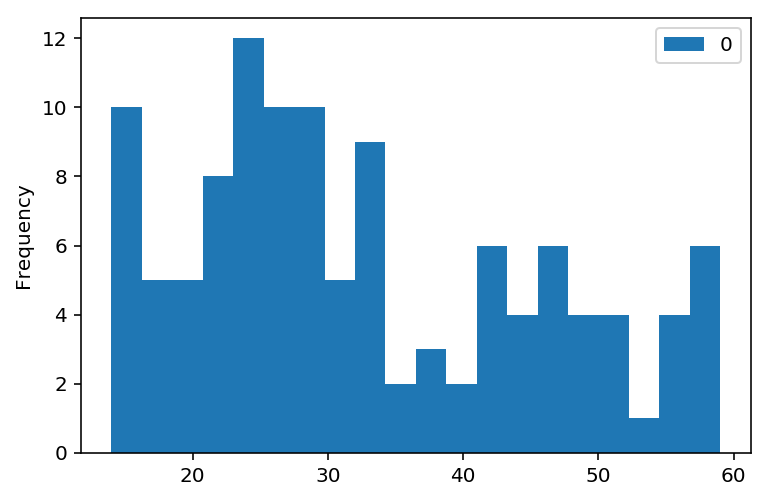

In [111]:
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])
    
hurricane_amount.plot.hist(bins=20)
plt.show()

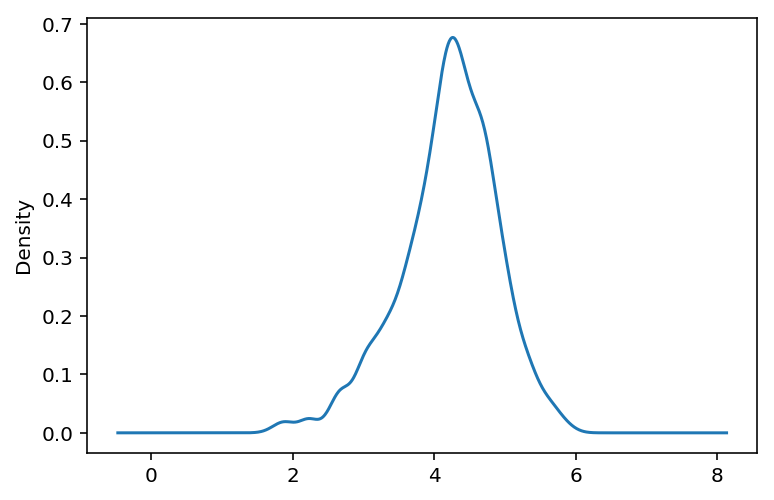

In [138]:
# Distribution of distance traveled in a 6 hour time interval for all hurricanes
dist = df[df['distance'] > 0]
dist = np.log(dist['distance'])
ser = pd.Series(dist)
ser.plot.kde()

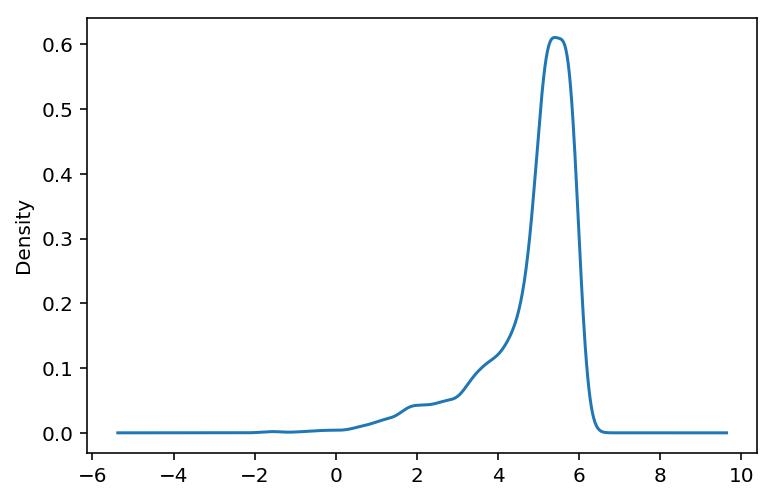

In [139]:
# Distribution of angle traveled in a 6 hour time interval for all hurricanes
direc = df[df['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot.kde()